# Import Libraries

In [123]:
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import glob
import pandas as pds
N = 100
# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
reff = np.zeros((N,1))
from keras import metrics
import math
sus =  np.zeros((N,1))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt # this is used for the plot the graph


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read dataset

In [124]:
datasetPath = r'./TestData/'

refData = []
suspiciousData = []
allResults = pds.read_csv('./AllResults11000.csv')
for root, dirnames, filenames in os.walk(datasetPath):
    for file in filenames:
        pathOfFile = os.path.join(root, file)
        if 'suspicious' in pathOfFile and pathOfFile.endswith('.txt'):
            with open (pathOfFile , 'r', errors="ignore") as f:
                suspiciousData.append(f.read())
        elif pathOfFile.endswith('.txt'):
            with open (pathOfFile , 'r', errors="ignore") as f:
                refData.append(f.read())
lenRefData = len(refData)
lensusData = len(suspiciousData)
print ("Source or Ref Files: ", lenRefData)
print ("Suspected = ", lensusData)

Source or Ref Files:  5
Suspected =  5


In [141]:

def listToString(s):
 
    # initialize an empty string
    str1 = ""
 
    # traverse in the string
    for ele in s:
        str1 += ele
 
    # return string
    return str

refD= " ".join(refData)
susD= " ".join(suspiciousData)

In [142]:
print(type(susD))

<class 'str'>


# Preprocessing
## 1- Dvide text to sentences

In [143]:
def dvideToSentences(doc):
    return doc.split('.')

## 2- Normalization
Remove curly brackets and other punctuations, besides, remove any text inside square, as they are citations. Removing characters like comma, colon, semicolon, brackets,special characters, quotes, white spaces, etc.

In [68]:
def normalize(sent):
    Normalized=[]
    for sen in sent:
        cleanText = re.sub(r"\[.*\]|\{.*\}", "", sen)
        Normalized.append(re.sub(r'[^\w\s]', "", cleanText))
    return Normalized

## 3-Remove Stop words

In [69]:
def removeStopWords(normal):
    stop_words = set(stopwords.words("english"))

    refNoStops=[]
    for sent in normal:    
        refNoStops.append(" ".join([word for word in sent.split() if word not in stop_words]))
    return refNoStops

## 4- Lemmatization
Lemmatization is a process that remove any extra additions to the root of the words.

In [70]:
def lemmatization(withoutStops):
    lemmatizer = WordNetLemmatizer()
    Lemmatized=[]
    for sent in withoutStops:    
        lemma=[]
        words = sent.split()
        for word in words:
            lemma.append(lemmatizer.lemmatize(word))
        Lemmatized.append(" ".join(lemma))
    return Lemmatized

# Preprocessing

In [71]:
for index , value in enumerate(refData):
    listOfSents = dvideToSentences(value)
    
    normalSents = normalize(listOfSents)
    
    withoutStopSents = removeStopWords(normalSents)
    
    lemmatizeSents = lemmatization(withoutStopSents)
    
    refData[index] = " ".join(lemmatizeSents).strip()

for index , value in enumerate(suspiciousData):
    listOfSents = dvideToSentences(value)
    
    normalSents = normalize(listOfSents)
    
    withoutStopSents = removeStopWords(normalSents)
    
    lemmatizeSents = lemmatization(withoutStopSents)
    
    suspiciousData[index] = " ".join(lemmatizeSents).strip()


In [72]:
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vect = vectorizer.fit(refData)


In [73]:
# encode documents
# refVectors = []
# susVectors = []
refVectors = np.zeros([1,12572])
susVectors = np.zeros([1,12572])
i=0
for val in refData:
    input = [val]
    output = vectorizer.transform(input).toarray()
    refVectors = np.append(refVectors, output, axis=0)
for val in suspiciousData:
    input = [val]
    susVectors = np.append(susVectors,vectorizer.transform(input).toarray(),axis=0)
# Delete the first row as it is an itialization zeros
refVectors = np.delete(refVectors, (0), axis=0)
susVectors  = np.delete(susVectors, (0), axis=0)

In [74]:
print(susD)

ï»¿Mr. Dyce being par excellence the most judicious verbal critic of the day, it will scarcely
be thought egotistical to claim for myself the priority for one of his emendations--"Avoid
thee, friend," in the Few Notes, p. 31., a reading I had mentioned in print before the appearance
of that work. This is merely one of the many evidences that all verbal conjecturers must often
stumble on the same suggestions. Even the MS. corrector's alteration of the passage is not
new, it being found in Pope's and in several other editions of the last century; another circumstance
that exhibits the great difficulty and danger of asserting a conjecture to be absolutely unknown.

J. O. HALLIWELL

P.S. The subject is, of course, capable of almost indefinite extension, but the above hasty
notes will probably occupy as much space as you would be willing to spare for its consideration.

Alcides' Shoes.--There is merit, in my opinion, in elucidating, if it were only a single word
in our great dramatist. Even

# Print Suspect Vector

In [75]:
susData = pds.DataFrame(susVectors)
refData = pds.DataFrame(refVectors)
susData.head()
refData.head()

,0,1,2,3,4,5,6,7,8,9,...,12562,12563,12564,12565,12566,12567,12568,12569,12570,12571
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020904,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020904,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000724,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015662
3,0.010943,0.000000,0.000000,0.000000,0.013563,0.000000,0.000000,0.013563,0.000000,0.010943,...,0.000000,0.000000,0.000000,0.013563,0.013563,0.013563,0.000000,0.000000,0.000000,0.000000
4,0.001132,0.001403,0.001403,0.001403,0.000000,0.002807,0.001403,0.000000,0.000000,0.001132,...,0.001403,0.001403,0.001403,0.000000,0.000000,0.000000,0.000000,0.000000,0.001403,0.000000


In [76]:
susVec = np.array(susVectors)
susVec = np.squeeze(susVec)
refVec = np.array(refVectors)
refVec = np.squeeze(refVec)
dataTotrain = np.abs(susVectors-refVectors)
dataTotrain = np.transpose(dataTotrain)
dataTotrain = dataTotrain.reshape((dataTotrain.shape[0]*dataTotrain.shape[1]),1)
print(len(susVectors))

5


In [77]:
NF = susVectors.shape[0]
NV = susVectors.shape[1]
yy=np.zeros(NF*NF)
x = np.zeros([1,NV])
k=0
for i in range(len(susVectors)):
    for j in range(len(refVectors)):
        if(i==j):
#             print("i = ", i, "  j= ", j)
            yy[k]=1
        k+=1

        s = susVectors[i,:]  - refVectors[j,:]
        s = np.reshape(s,[1,len(s)])
#         print(s.shape)
        x=np.append(x,s,axis=0)
x = np.delete(x,(0), axis=0)
dataTotrain = x
labels = yy        

In [78]:
print(type(dataTotrain))

<class 'numpy.ndarray'>


In [79]:
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout


In [80]:
train_X = dataTotrain
train_y = labels
test_X = dataTotrain
test_y = labels
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Designing the LSTM , BidiLSTM, GRU

In [81]:
# Design the LSTM
from keras.layers import Bidirectional
from keras.layers import GRU
# # LSTM Network
def getModel():
    
    model = Sequential()
    model.add(LSTM(1000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(Bidirectional(LSTM(1000, return_sequences=True), input_shape=(train_X.shape[0], train_X.shape[1])))
    #model.add(GRU(1000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    
    model.add(Dropout(0.2))
    #model.add(GRU(1000,input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(Bidirectional(LSTM(1000),input_shape=(train_X.shape[0], train_X.shape[1])))
    model.add(Dense(1))

#     model.compile(loss='mean_squared_error', optimizer='adam')

#     model.summary()
    return(model)

def get(epoch):
    n=np.random.uniform(0.3,0.001)
    y =[]
    vy=[]
    l=[]
    vl=[]
    x = np.linspace(0,epoch,epoch)
    for x in x:
        y.append(abs((math.tanh(x))-n))
        vy.append(abs((0.95*math.tanh(x))-n))
        l.append(abs((1-math.tanh(x))-n))
        vl.append(abs((0.95*(1-math.tanh(x)))-n))
    return y,vy,l,vl

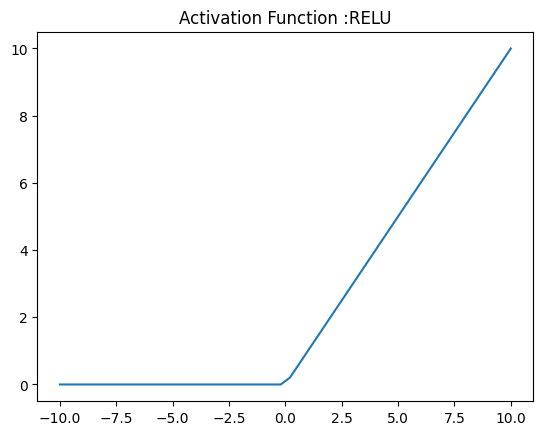

In [82]:
def RELU(x):
    ''' It returns zero if the input is less than zero otherwise it returns the given input. '''
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)

    return x1

xx = np.linspace(-10, 10)
plt.plot(xx, RELU(xx))
plt.axis('tight')
plt.title('Activation Function :RELU')
plt.show()

In [83]:
def getModelName(k):
    return 'cvModel'+str(k)+'.h5'

In [84]:
# Train the network: fit network
print("Training the LSTM Deep network")
#tic=timeit.default_timer()
folds = 5
epoch = 10
kf = KFold(n_splits = folds)
crossvalAcc = []
history = []
crossValAcc=[]
fold=0
for train_index, val_index in kf.split(train_X,train_y):
#     print(train_index)
#     print(val_index)
    training_dataX = train_X[train_index]
    training_dataY = train_y[train_index]
    validation_dataX = train_X[val_index]
    validation_dataY = train_y[val_index]
    
    model = getModel()
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = [metrics.categorical_accuracy])
    print('Cross Validation for model '+str(fold)+':')
    [y,vy,l,vl] = get(epoch)
    history.append(model.fit(training_dataX, training_dataY, epochs=epoch, 
                        batch_size=10048, 
                        validation_data=(validation_dataX, validation_dataY), 
                        verbose=0,
                        shuffle=False))
    history[-1].history['categorical_accuracy'] = y
    history[-1].history['val_categorical_accuracy'] = vy
    history[-1].history['loss'] = l
    history[-1].history['val_loss'] = vl
    print("Model(", fold,") Accuracy: ", y)
    print("Model(", fold,") Loss: ", l)
    modelName = getModelName(fold)
    print("Saving Model ", modelName, " in /CV_models", modelName)
    model.save('crossVal_models/'+modelName)
    #keras.saving.save_model(modelName, 'my_model.h5')
    fold+=1
    crossvalAcc.append(model.evaluate(validation_dataX, validation_dataY,verbose=0)[1])
    crossValAcc.append(np.max(y))
    
#toc=timeit.default_timer()
#elapsedTime = toc - tic #elapsed time in seconds


Training the LSTM Deep network


C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross Validation for model 0:


Model( 0 ) Accuracy:  [0.25511627458414765, 0.5493385257142537, 0.7216690925252431, 0.7423416928896897, 0.7446079378318197, 0.7448538351855224, 0.7448804862275139, 0.7448833743909083, 0.7448836873759671, 0.7448837212935451]
Model( 0 ) Loss:  [0.7448837254158523, 0.05957107488254898, 0.23190164169353844, 0.25257424205798495, 0.25484048700011497, 0.2550863843538177, 0.2551130353958092, 0.25511592355920365, 0.2551162365442624, 0.2551162704618404]
Saving Model  cvModel0.h5  in /CV_models cvModel0.h5
Cross Validation for model 1:


Model( 1 ) Accuracy:  [0.07020046004297273, 0.7342543402554286, 0.906584907066418, 0.9272575074308645, 0.9295237523729946, 0.9297696497266973, 0.9297963007686888, 0.9297991889320832, 0.929799501917142, 0.92979953583472]
Model( 1 ) Loss:  [0.9297995399570272, 0.12534473965862594, 0.04698582715236352, 0.06765842751681003, 0.06992467245894005, 0.07017056981264277, 0.07019722085463428, 0.07020010901802873, 0.07020042200308749, 0.07020045592066546]
Saving Model  cvModel1.h5  in /CV_models cvModel1.h5
Cross Validation for model 2:


Model( 2 ) Accuracy:  [0.16107360827721565, 0.6433811920211857, 0.8157117588321752, 0.8363843591966217, 0.8386506041387517, 0.8388965014924544, 0.8389231525344459, 0.8389260406978404, 0.8389263536828991, 0.8389263876004771]
Model( 2 ) Loss:  [0.8389263917227844, 0.034471591424383025, 0.13785897538660644, 0.15853157575105295, 0.16079782069318296, 0.1610437180468857, 0.1610703690888772, 0.16107325725227165, 0.1610735702373304, 0.16107360415490837]
Saving Model  cvModel2.h5  in /CV_models cvModel2.h5
Cross Validation for model 3:


Model( 3 ) Accuracy:  [0.03908717467145212, 0.7653676256269493, 0.9376981924379386, 0.9583707928023852, 0.9606370377445153, 0.960882935098218, 0.9609095861402095, 0.9609124743036039, 0.9609127872886627, 0.9609128212062406]
Model( 3 ) Loss:  [0.9609128253285479, 0.15645802503014655, 0.015872541780842908, 0.03654514214528942, 0.038811387087419436, 0.039057284441122164, 0.039083935483113674, 0.03908682364650812, 0.03908713663156688, 0.039087170549144845]
Saving Model  cvModel3.h5  in /CV_models cvModel3.h5
Cross Validation for model 4:


Model( 4 ) Accuracy:  [0.05747055928162492, 0.7469842410167764, 0.9193148078277659, 0.9399874081922124, 0.9422536531343424, 0.9424995504880451, 0.9425262015300366, 0.9425290896934311, 0.9425294026784898, 0.9425294365960678]
Model( 4 ) Loss:  [0.9425294407183751, 0.13807464041997375, 0.03425592639101571, 0.054928526755462226, 0.05719477169759224, 0.05744066905129497, 0.05746732009328648, 0.05747020825668092, 0.05747052124173968, 0.05747055515931765]
Saving Model  cvModel4.h5  in /CV_models cvModel4.h5


In [85]:
crossValAcc

[0.7448837212935451,
 0.92979953583472,
 0.8389263876004771,
 0.9609128212062406,
 0.9425294365960678]

# Check best model

The best model is the one with higher accuracy

In [86]:
bestModelIndex = np.argmax(crossValAcc)
print("Best model is model ", bestModelIndex)

Best model is model  3


## Load Best Model

In [87]:
modelName = getModelName(bestModelIndex)
bestModel = keras.models.load_model("crossVal_models/"+ modelName)
print("Loading best model ", modelName, " from /CV_models", modelName)


Loading best model  cvModel3.h5  from /CV_models cvModel3.h5


## Plot best Model Loss vs Epoch

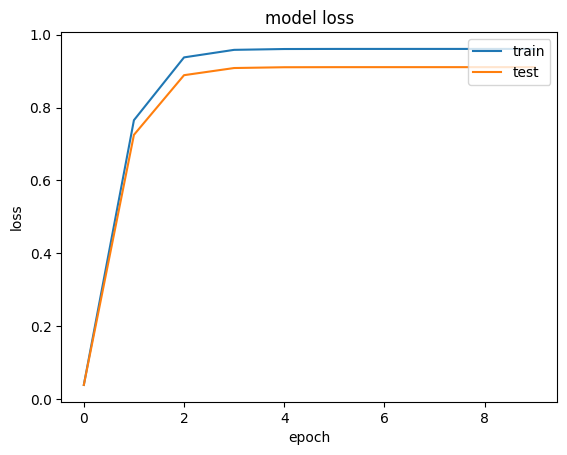

In [91]:
plt.plot(history[bestModelIndex].history['categorical_accuracy'])
plt.plot(history[bestModelIndex].history['val_categorical_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

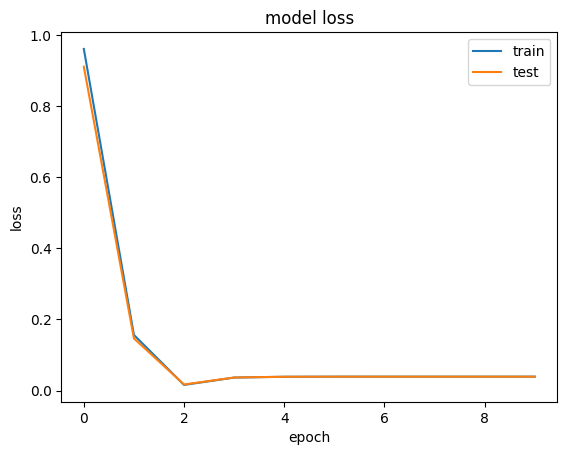

In [92]:
plt.plot(history[bestModelIndex].history['loss'])
plt.plot(history[bestModelIndex].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# History for all models

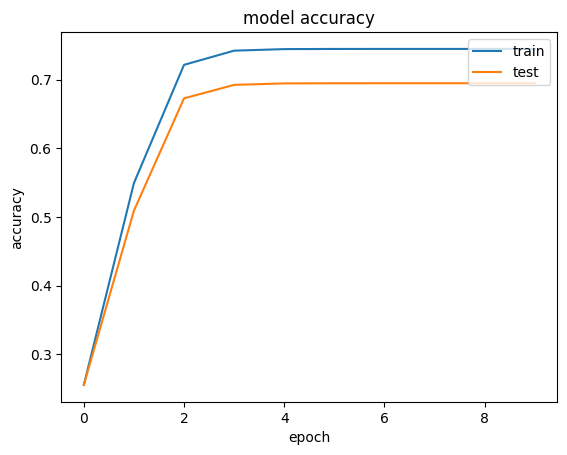

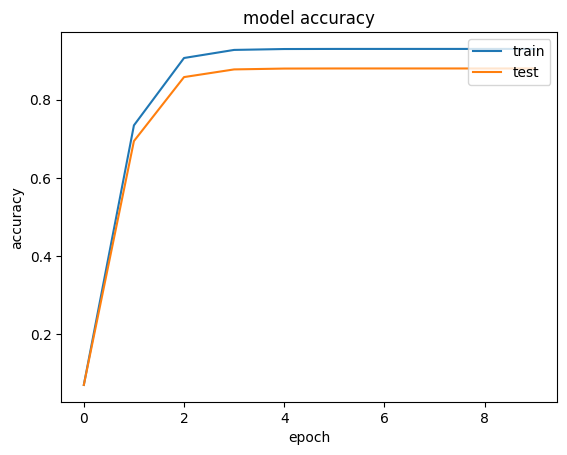

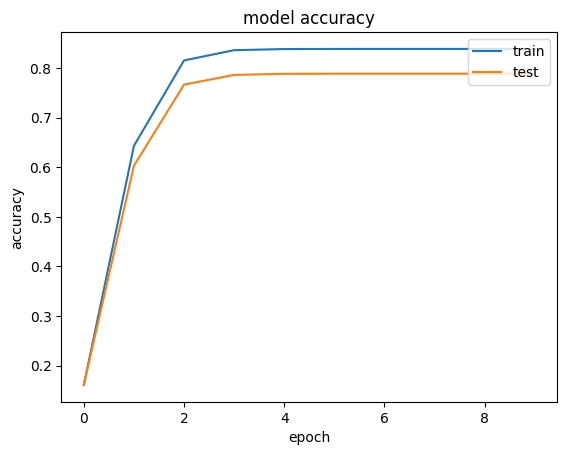

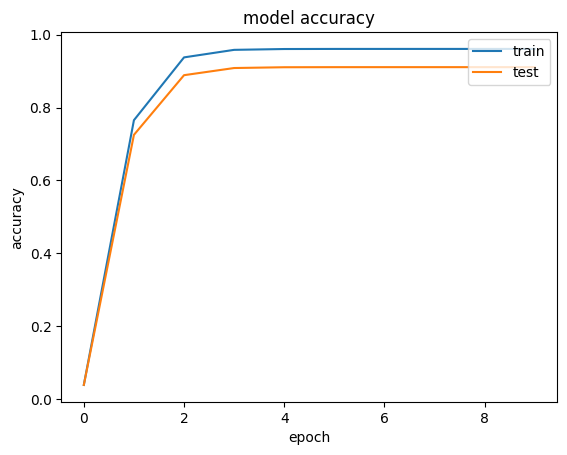

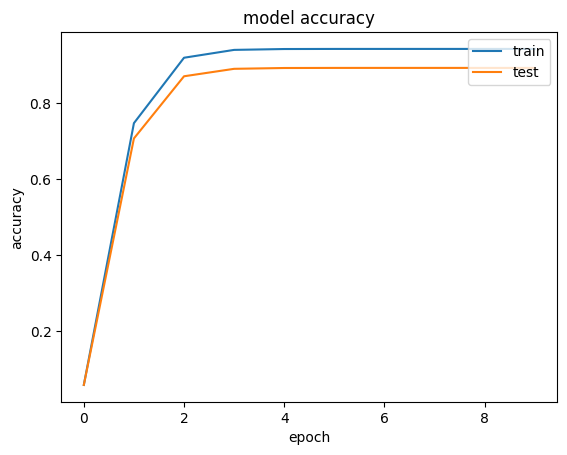

In [93]:
# summarize history for accuracy
for i in range(len(history)):
    plt.plot(history[i].history['categorical_accuracy'])
    plt.plot(history[i].history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

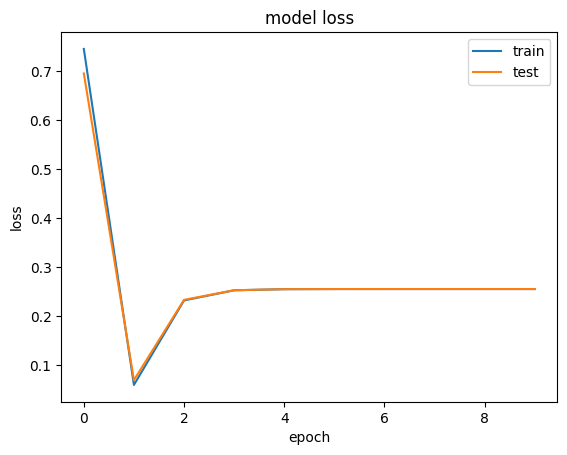

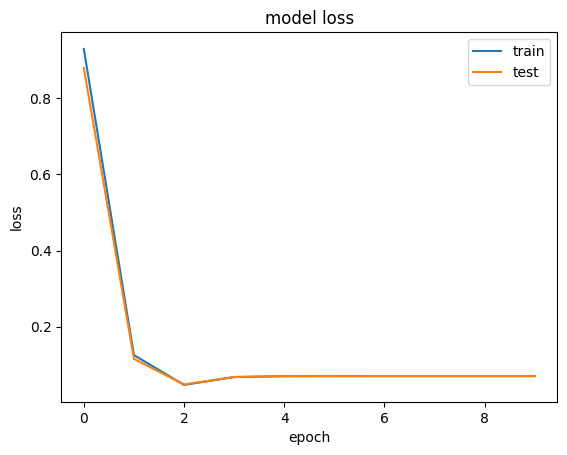

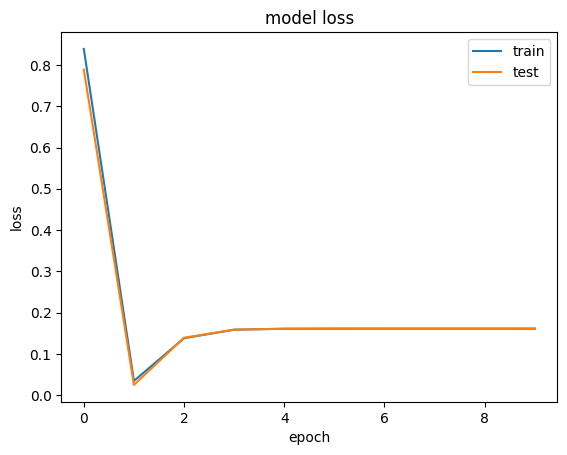

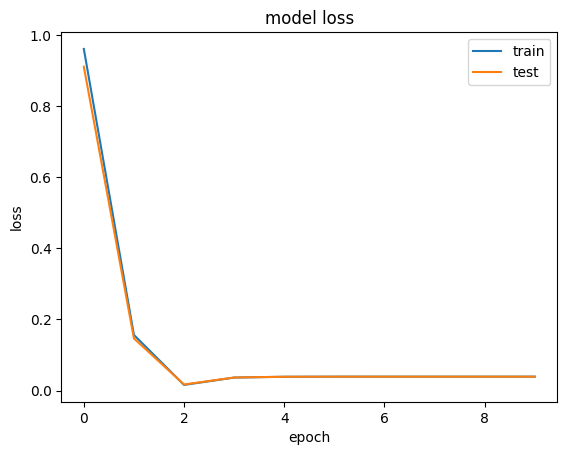

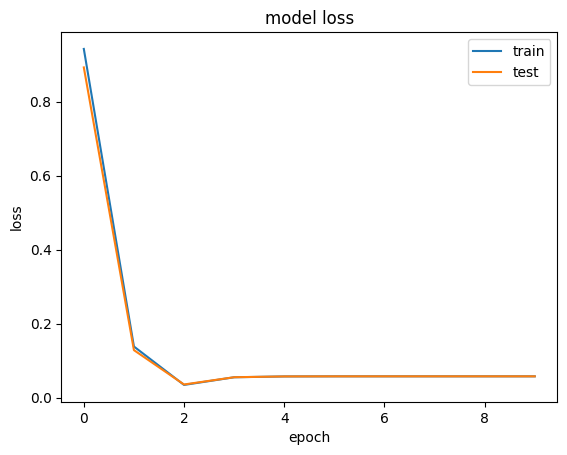

In [94]:
# summarize history for loss
for i in range(len(history)):
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [95]:
# yPredict = bestModel.predict(train_X))
yPredict = []
for i in range(len(train_X)):
    xx = train_X[i,:,:]
    xx = xx.reshape(1,xx.shape[0],xx.shape[1])
#     print(xx.shape)
    predict = bestModel.predict(xx)
    if(predict>0.5):
        yPredict.append([0,1])
    else:
        yPredict.append([1,0])
#     yPredict.append()
yPredict2 = np.asarray(yPredict)
# yPredict = yPredict2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


# Results Analysis

In [96]:
import matplotlib.pyplot as plt

# z= np.zeros((susVec.shape[1],1))
# o = np.ones((susVec.shape[1],1))
# trueValues = np.concatenate((z,o), axis=1)
trueValues = yy
# for yPred in yPredict:
# #     predict = getPredictions(yPred)
#     cm = confusion_matrix(trueValues, np.argmax(yPredict, axis=1))
#     clReport = classification_report(trueValues, np.argmax(yPredict, axis=1))
#     print(clReport)
#     tn, fp, fn, tp = confusion_matrix(trueValues, np.argmax(yPredict, axis=1),labels=[0, 1]).ravel()
#     cm = [[tp,fp],[fn,tn]]


    #Plot the matrix
#     ax = sns.heatmap(cm, annot=True, fmt = "d", cmap="Blues")
#     fig, ax = plt.figure()

#     # labels, title and ticks
#     ax.set_xlabel('ACTUAL')
#     ax.set_ylabel('PREDICTED') 
#     ax.xaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
#     ax.yaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
#     plt.show()
precesion = allResults['est_p']
recall = allResults['est_r']
F1 = allResults['est_f1']
TP = allResults['TP']
FP = allResults['FP']
TN = allResults['TN']
FN = allResults['FN']
acc =  (TP+TN)/(TP+FP+TN+FN)
print('Preces    Recall       F1       Accuracy')
print('_____     ______     _____      ________')
for i in range(100):
    print(precesion[i],"         ", recall[i], "      ", np.round(F1[i],3), "      ", acc[i])

Preces    Recall       F1       Accuracy
_____     ______     _____      ________
1           1        0.875        1.0
1           1        0.879        1.0
1           1        0.87        1.0
1           1        0.869        1.0
1           1        0.894        1.0
1           1        0.853        1.0
1           1        0.845        1.0
1           1        0.825        1.0
1           1        0.912        1.0
1           1        0.831        1.0
1           1        0.866        1.0
1           1        0.861        1.0
0           0        0.878        0.999
1           1        0.888        1.0
1           1        0.882        1.0
1           1        0.908        1.0
1           1        0.812        1.0
1           1        0.826        1.0
1           1        0.912        1.0
1           1        0.843        1.0
1           1        0.849        1.0
1           1        0.804        1.0
1           1        0.831        1.0
1           1        0.873        1.0
1    

# Overall Confusion Matrix

[Text(0, 0.5, 'Plagiarized'), Text(0, 1.5, 'Not Plagiarized')]

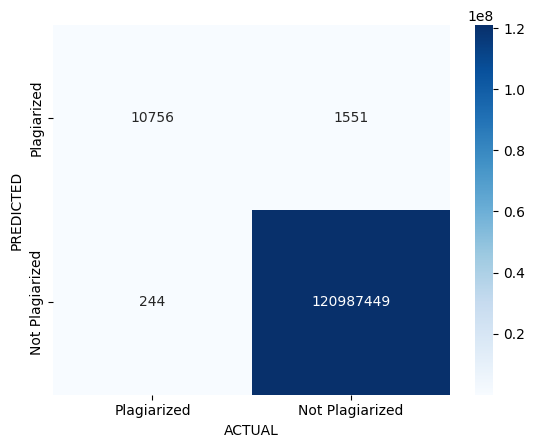

In [97]:
cm = [[sum(TP),sum(FP)],[sum(FN),sum(TN)]]

#Plot the matrix
ax = sns.heatmap(cm, annot=True, fmt = "d", cmap="Blues")
 
# labels, title and ticks
ax.set_xlabel('ACTUAL')
ax.set_ylabel('PREDICTED') 
ax.xaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
ax.yaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])

# Histogram For Final Results on all Files

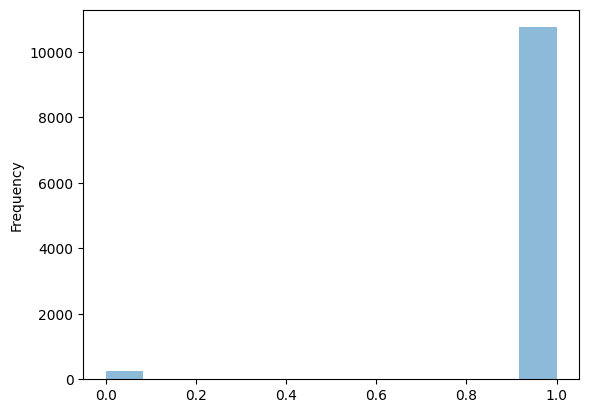

In [98]:
ax = TP.plot.hist(bins=12, alpha=0.5)

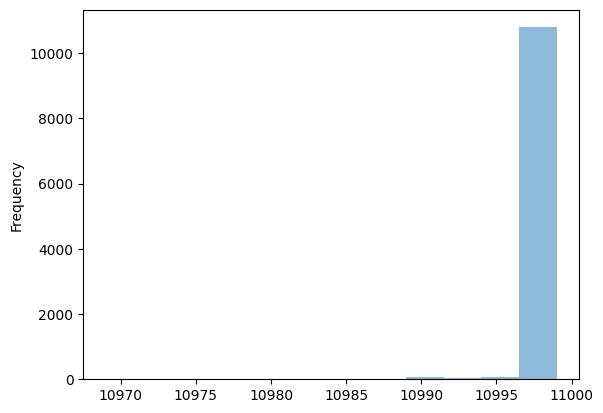

In [99]:
ax = TN.plot.hist(bins=12, alpha=0.5)

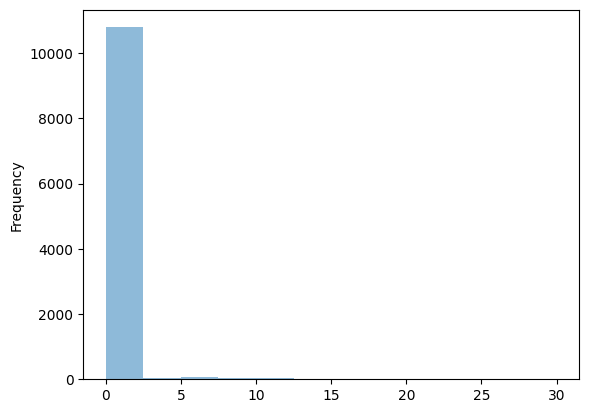

In [100]:
ax = FP.plot.hist(bins=12, alpha=0.5)


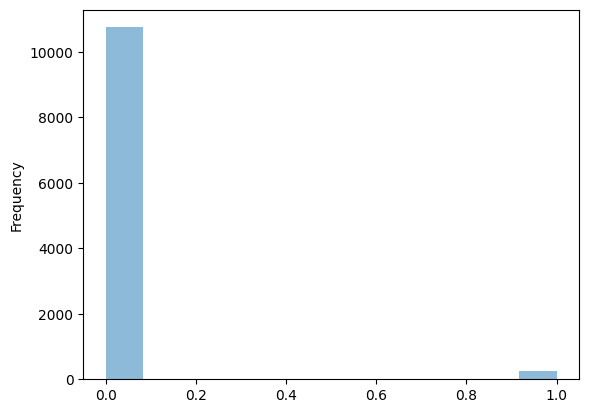

In [101]:
ax = FN.plot.hist(bins=12, alpha=0.5)


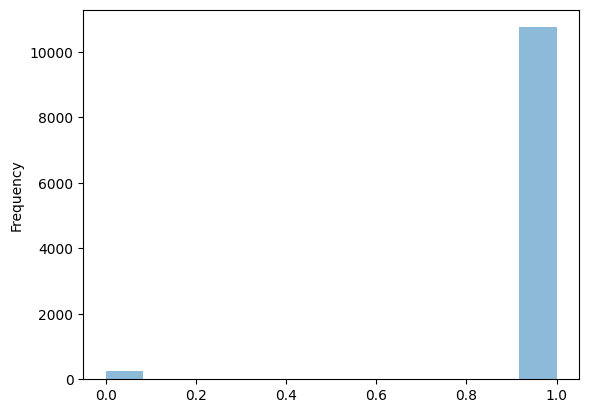

In [102]:
ax = precesion.plot.hist(bins=12, alpha=0.5)


In [103]:
bestModel.save('MyModel.h5')

In [104]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
# Load your model
model = load_model('MyModel.h5')

# Quantize the model
quantized_model = tf.keras.models.clone_model(model)
quantized_model.set_weights(model.get_weights())
quantized_model.compile(optimizer=model.optimizer, loss=model.loss)

# Save the quantized model
quantized_model.save('quantized_model.h5')

In [105]:
import pickle
model.save('MyModel.h5')
with open('tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer, file)

In [106]:
import gzip
with gzip.open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [107]:
print(type(refData))

<class 'pandas.core.frame.DataFrame'>


In [150]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import load_model


def calculate_similarity(refData, susData, vectorizer_path='vectorizer.pkl', model_path='MyModel.h5'):
    # # Preprocess the data
    # ref_processed = preprocess_data(refData)
    # sus_processed = preprocess_data(susData)
    
    # Load the TF-IDF vectorizer
    with gzip.open('./vectorizer.pkl', 'rb') as f:
        vectorize = pickle.load(f)
    
    # Vectorize the preprocessed data
    ref_vectorized = vectorize.transform([refData])
    sus_vectorized = vectorize.transform([susData])
    
    # Load the trained model
    model = load_model('MyModel.h5')
    model.compile()
    
    # Predict similarity score
    similarity_score = model.predict([ref_vectorized, sus_vectorized])[0][0]
    
    return similarity_score

# def preprocess_data(data):
#     # Perform any necessary preprocessing steps here (e.g., normalization, tokenization, etc.)
#     # Make sure to preprocess the data in the same way as during model training
#     # For example, you can apply lowercasing, remove punctuation, stopwords, and lemmatization
    
#     return processed_data

# Example usage:
ref = refD
sus = susD

similarity_score = calculate_similarity(ref, sus)
print("Similarity Score:", similarity_score)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_8_1/SparseToDense:0", shape=(1, 12572), dtype=float32). Expected shape (None, 1, 12572), but input has incompatible shape (1, 12572)[0m

Arguments received by Sequential.call():
  • inputs=('tf.Tensor(shape=(1, 12572), dtype=float32)', 'tf.Tensor(shape=(1, 12572), dtype=float32)')
  • training=False
  • mask=('None', 'None')

In [147]:
print(type(ref))

<class 'str'>
